In [4]:
from utils import convert_hom_to_het

import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn.functional as F

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import HeteroConv, SAGEConv, Linear, global_mean_pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [5]:
# Load the ENZYMES dataset
hom_dataset = TUDataset(root='data', name='ENZYMES')                          # This has 3 one-hot encodings
hom_dataset_attr = TUDataset(root='data', name='ENZYMES', use_node_attr=True) # This has 3 one-hot encodings and 18 features

In [6]:
het_dataset = []
for hom_data in hom_dataset:
    het_dataset.append(convert_hom_to_het(hom_data, is_directed=False))
het_dataset.__len__()

600

In [7]:
het_dataset[0]

HeteroData(
  y=[1],
  A={ x=[24, 1] },
  B={ x=[13, 1] },
  C={ x=[0, 1] },
  (A, connects, A)={ edge_index=[2, 86] },
  (A, connects, B)={ edge_index=[2, 17] },
  (A, connects, C)={ edge_index=[2, 0] },
  (B, connects, B)={ edge_index=[2, 48] },
  (B, connects, C)={ edge_index=[2, 0] },
  (C, connects, C)={ edge_index=[2, 0] }
)

In [8]:
train_dataset, test_dataset = train_test_split(het_dataset, test_size=0.2)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [9]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, conv=SAGEConv , act=F.relu, intra_aggr='mean', inter_aggr='sum'):
        super().__init__()
        conv1_dict = {edge_type: conv((-1, -1), hidden_channels, aggr=intra_aggr) for edge_type in metadata[1]}
        self.conv1 = HeteroConv(conv1_dict, aggr=inter_aggr)

        conv2_dict = {edge_type: conv((-1, -1), hidden_channels, aggr=intra_aggr)for edge_type in metadata[1]}
        self.conv2 = HeteroConv(conv2_dict, aggr=inter_aggr)
        self.classifier = Linear(len(metadata[0]) * hidden_channels, out_channels)
        self.act = act

        
    def forward(self, x_dict, edge_index_dict, batch_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: self.act(x) for key, x in x_dict.items()}

        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: self.act(x) for key, x in x_dict.items()}

        batch_size = max(batch.max().item() + 1 for batch in batch_dict.values() if batch.numel() > 0)
        pooled_list = [global_mean_pool(x, batch_dict[node_type], size=batch_size) for node_type, x in x_dict.items()]

        graph_emb = torch.cat(pooled_list, dim=1)
        out = self.classifier(graph_emb)
        return out



In [10]:
# Get the metadata to build HeteroGNN
edge_types = het_dataset[0].edge_types
node_types = het_dataset[0].node_types
metadata = (node_types, edge_types)
metadata

(['A', 'B', 'C'],
 [('A', 'connects', 'A'),
  ('A', 'connects', 'B'),
  ('A', 'connects', 'C'),
  ('B', 'connects', 'B'),
  ('B', 'connects', 'C'),
  ('C', 'connects', 'C')])

In [11]:
model = HeteroGNN(metadata, 16, 32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
model.conv2.convs

ModuleDict(
  (<A___connects___A>): SAGEConv((-1, -1), 16, aggr=mean)
  (<A___connects___B>): SAGEConv((-1, -1), 16, aggr=mean)
  (<A___connects___C>): SAGEConv((-1, -1), 16, aggr=mean)
  (<B___connects___B>): SAGEConv((-1, -1), 16, aggr=mean)
  (<B___connects___C>): SAGEConv((-1, -1), 16, aggr=mean)
  (<C___connects___C>): SAGEConv((-1, -1), 16, aggr=mean)
)

In [12]:
def train(model, loader, optimizer, criterion, device="cpu"):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in loader:
        batch.to(device)
        optimizer.zero_grad()
        logits = model(batch.x_dict, batch.edge_index_dict, batch.batch_dict)
        loss = criterion(logits, batch.y)
        
        preds = logits.argmax(dim=1).detach().cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(batch.y.cpu().numpy())
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.y.size(0)

    avg_loss = total_loss / len(loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, accuracy, f1

def test(model, loader, criterion, device="cpu"):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            batch.to(device)
            logits = model(batch.x_dict, batch.edge_index_dict, batch.batch_dict)
            loss = criterion(logits, batch.y)
            
            preds = logits.argmax(dim=1).cpu()
            all_preds.extend(preds.numpy())
            all_labels.extend(batch.y.cpu().numpy())
            total_loss += loss.item() * batch.y.size(0)

    avg_loss = total_loss / len(loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, accuracy, f1

In [13]:
# Initialize tracking
metrics = {
    'train_loss': [],
    'test_loss': [],
    'train_acc': [],
    'test_acc': [],
    'train_f1': [],
    'test_f1': []
}

best_val_loss = float('inf')
epochs = 15

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc, test_f1 = test(model, test_loader, criterion)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['test_loss'].append(test_loss)
    metrics['train_acc'].append(train_acc)
    metrics['test_acc'].append(test_acc)
    metrics['train_f1'].append(train_f1)
    metrics['test_f1'].append(test_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Test F1: {test_f1:.4f}\n")

Epoch 1/15
Train Loss: 3.0259 | Test Loss: 2.5619
Train Acc: 0.1125 | Test Acc: 0.2000
Train F1: 0.0529 | Test F1: 0.0983

Epoch 2/15
Train Loss: 2.2011 | Test Loss: 1.9505
Train Acc: 0.1792 | Test Acc: 0.1833
Train F1: 0.1012 | Test F1: 0.1010

Epoch 3/15
Train Loss: 1.8737 | Test Loss: 1.8154
Train Acc: 0.2021 | Test Acc: 0.1583
Train F1: 0.1618 | Test F1: 0.1030

Epoch 4/15
Train Loss: 1.8142 | Test Loss: 1.7941
Train Acc: 0.1958 | Test Acc: 0.1417
Train F1: 0.1368 | Test F1: 0.0782

Epoch 5/15
Train Loss: 1.7972 | Test Loss: 1.7852
Train Acc: 0.2000 | Test Acc: 0.1917
Train F1: 0.1506 | Test F1: 0.1337

Epoch 6/15
Train Loss: 1.7859 | Test Loss: 1.7795
Train Acc: 0.2292 | Test Acc: 0.1917
Train F1: 0.1820 | Test F1: 0.1306

Epoch 7/15
Train Loss: 1.7766 | Test Loss: 1.7744
Train Acc: 0.2375 | Test Acc: 0.1917
Train F1: 0.1876 | Test F1: 0.1306

Epoch 8/15
Train Loss: 1.7679 | Test Loss: 1.7697
Train Acc: 0.2354 | Test Acc: 0.2000
Train F1: 0.1847 | Test F1: 0.1401

Epoch 9/15
Train

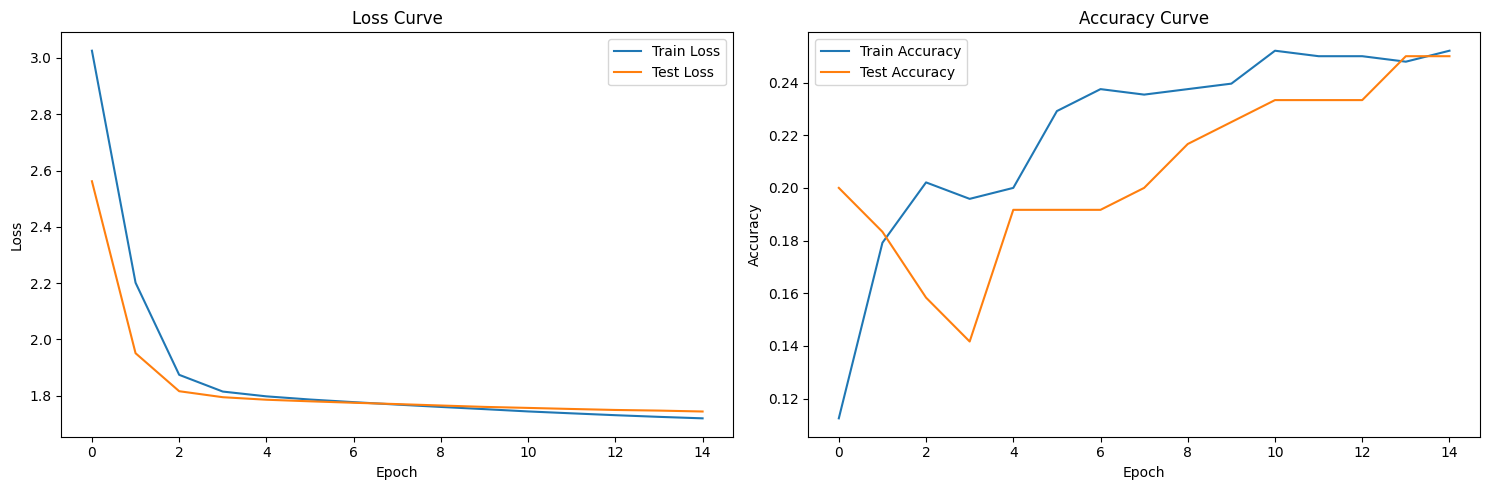

,Epoch,Train Loss,Test Loss,Train Acc,Test Acc,Train F1,Test F1
0,1,3.0259,2.5619,0.1125,0.2000,0.0529,0.0983
1,2,2.2011,1.9505,0.1792,0.1833,0.1012,0.1010
2,3,1.8737,1.8154,0.2021,0.1583,0.1618,0.1030
3,4,1.8142,1.7941,0.1958,0.1417,0.1368,0.0782
4,5,1.7972,1.7852,0.2000,0.1917,0.1506,0.1337
5,6,1.7859,1.7795,0.2292,0.1917,0.1820,0.1306
6,7,1.7766,1.7744,0.2375,0.1917,0.1876,0.1306
7,8,1.7679,1.7697,0.2354,0.2000,0.1847,0.1401
8,9,1.7595,1.7646,0.2375,0.2167,0.1812,0.1509
9,10,1.7517,1.7597,0.2396,0.2250,0.1785,0.1526


In [14]:
def plot_metrics(metrics):
    plt.figure(figsize=(15, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['test_loss'], label='Test Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_acc'], label='Train Accuracy')
    plt.plot(metrics['test_acc'], label='Test Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def create_metrics_table(metrics):
    df = pd.DataFrame({
        'Epoch': range(1, len(metrics['train_loss'])+1),
        'Train Loss': metrics['train_loss'],
        'Test Loss': metrics['test_loss'],
        'Train Acc': metrics['train_acc'],
        'Test Acc': metrics['test_acc'],
        'Train F1': metrics['train_f1'],
        'Test F1': metrics['test_f1']
    })
    return df.style.format({
        'Train Loss': '{:.4f}',
        'Test Loss': '{:.4f}',
        'Train Acc': '{:.4f}',
        'Test Acc': '{:.4f}',
        'Train F1': '{:.4f}',
        'Test F1': '{:.4f}'
    }).background_gradient(cmap='Blues', subset=pd.IndexSlice[:, ['Train Acc', 'Test Acc']])

# After training
plot_metrics(metrics)
display(create_metrics_table(metrics))